Toxic-BERT Enhancement with Tagging Methods
===========================================

This script implements and evaluates different tagging strategies to improve 
the performance of `unitary/toxic-bert`.

Strategy Overview:
1. Explicit Toxicity Markers: Add toxicity type tags ([THREAT][INSULT])
2. Contextual Intensity Tagging: Add intensity markers ([INTENSITY:HIGH][CAPS:HEAVY])
3. Target-Oriented Tagging: Identify attack targets ([TARGET:PERSON][DIRECTION:DIRECT])
4. Linguistic Feature Tagging: Add structural features ([LENGTH:SHORT][QUESTION])
5. Semantic Context Tagging: Add domain context ([CONTEXT:POLITICAL][EMOTION:ANGER])

Each method aims to provide additional context to help the model better 
understand and classify toxic comments.

In [1]:
import sys
import os
from pathlib import Path

notebook_dir = Path.cwd()
if notebook_dir not in sys.path:
    sys.path.append(str(notebook_dir))

import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report
import mlflow
import mlflow.pytorch
from tqdm import tqdm
import warnings


# Import our tagging class
parent_dir = os.path.abspath('..')  # Un nivel arriba desde notebooks/
sys.path.append(parent_dir)
from src.training.toxic_tagging_methods import ToxicCommentTagger, ImprovedToxicCommentTagger


warnings.filterwarnings('ignore')

c:\Users\analyst4\AppData\Local\anaconda3\envs\toxic_py311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\analyst4\AppData\Local\anaconda3\envs\toxic_py311\Lib\site-packages\transformers\utils\generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


In [2]:


# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## LOAD DATA ##

In [3]:
# Load data
base_dir = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
data_dir = base_dir / "src" / "data" / "raw"

train = pd.read_csv(data_dir / "train.csv")
test = pd.read_csv(data_dir / "test.csv")
test_labels = pd.read_csv(data_dir / "test_labels.csv")

labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

print(f'Train samples: {len(train)}')
print(f'Test samples: {len(test)}')
print(f'Labels: {labels}')

Train samples: 159571
Test samples: 153164
Labels: ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']


## UTILITIES ##

In [4]:
def prepare_test_for_evaluation(test_df, test_labels_df):
    """Prepare test data for evaluation by filtering valid samples."""
    valid_mask = (test_labels_df[labels] != -1).all(axis=1)
    print(f'Test samples: {len(test_df)} total, {valid_mask.sum()} valid for evaluation')
    return test_df[valid_mask].copy(), test_labels_df[valid_mask].copy()

def create_balanced_subset(df, labels, n_per_class=200):
    """Create balanced subset for fair evaluation."""
    idxs = set()
    print(f'Creating balanced subset with {n_per_class} samples per class...')
    
    for i, label in enumerate(labels):
        class_idxs = np.where(df[label].values == 1)[0]
        available = len(class_idxs)
        to_sample = min(n_per_class, available)
        
        if available > 0:
            chosen = np.random.choice(class_idxs, to_sample, replace=False)
            idxs.update(chosen)
            print(f'  {label}: {to_sample}/{available} samples')
        else:
            print(f'  {label}: 0 samples available!')
    
    # Add neutral samples
    neutral_idxs = np.where(df[labels].sum(axis=1) == 0)[0]
    neutral_available = len(neutral_idxs)
    neutral_to_sample = min(n_per_class, neutral_available)
    
    if neutral_available > 0:
        chosen_neutral = np.random.choice(neutral_idxs, neutral_to_sample, replace=False)
        idxs.update(chosen_neutral)
        print(f'  neutral: {neutral_to_sample}/{neutral_available} samples')
    
    idxs = list(idxs)
    balanced_df = df.iloc[idxs].copy()
    print(f'Total balanced samples: {len(balanced_df)}')
    return balanced_df

## PREPARE FOR EVALUATION ##

In [5]:
# Prepare evaluation datasets
test_eval, test_labels_eval = prepare_test_for_evaluation(test, test_labels)

# Split training data
X = train['comment_text'].values
y = train[labels].values

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y[:, 0]
)

print(f'Train size: {len(X_train)}')
print(f'Validation size: {len(X_val)}')
print(f'Test evaluation size: {len(test_eval)}')

Test samples: 153164 total, 63978 valid for evaluation
Train size: 143613
Validation size: 15958
Test evaluation size: 63978


## CREATE BALANCED EVALUATION SETS ##

In [6]:
# Create balanced evaluation sets
np.random.seed(42)  # For reproducibility

# Create balanced validation set
val_df_temp = pd.DataFrame({'comment_text': X_val})
val_df_temp[labels] = y_val
balanced_val_df = create_balanced_subset(val_df_temp, labels, n_per_class=150)

print('\nBalanced validation set created')
print('Class distribution:')
for label in labels:
    count = balanced_val_df[label].sum()
    print(f'  {label}: {count} samples')

Creating balanced subset with 150 samples per class...
  toxic: 150/1529 samples
  severe_toxic: 149/149 samples
  obscene: 150/847 samples
  threat: 50/50 samples
  insult: 150/800 samples
  identity_hate: 150/153 samples
  neutral: 150/14355 samples
Total balanced samples: 759

Balanced validation set created
Class distribution:
  toxic: 584 samples
  severe_toxic: 149 samples
  obscene: 451 samples
  threat: 50 samples
  insult: 439 samples
  identity_hate: 153 samples


## TAGGING SYSTEM ##

In [7]:
# Initialize the tagger
tagger = ImprovedToxicCommentTagger(
    base_model_name='unitary/toxic-bert',
    device=str(device)
)

print('ImprovedToxicCommentTagger initialized successfully!')

Initialized ImprovedToxicCommentTagger with unitary/toxic-bert on cuda
ImprovedToxicCommentTagger initialized successfully!


In [8]:
# Set MLflow experiment
mlflow.set_experiment('Toxic_BERT_Tagging_Methods')

# Prepare evaluation data
eval_texts = balanced_val_df['comment_text'].tolist()
eval_labels = balanced_val_df[labels].values

print(f'Evaluating on {len(eval_texts)} balanced samples')
print(f'Label distribution:')
for i, label in enumerate(labels):
    pos_samples = eval_labels[:, i].sum()
    print(f'  {label}: {pos_samples} positive samples')

2025/08/07 11:18:10 INFO mlflow.tracking.fluent: Experiment with name 'Toxic_BERT_Tagging_Methods' does not exist. Creating a new experiment.


Evaluating on 759 balanced samples
Label distribution:
  toxic: 584 positive samples
  severe_toxic: 149 positive samples
  obscene: 451 positive samples
  threat: 50 positive samples
  insult: 439 positive samples
  identity_hate: 153 positive samples


In [9]:
# Define methods to evaluate
methods_to_evaluate = [
    'baseline',           # No tagging
    'explicit_markers',   # Method 1
    'intensity_tagging',  # Method 2
    'target_tagging',     # Method 3
    'linguistic_features',# Method 4
    'semantic_context'    # Method 5
]

In [10]:
# Métodos disponibles (más conservadores)
improved_methods = [
    'baseline',
    'high_confidence_explicit',
    'subtle_toxicity', 
    'contextual_amplification',
    'threat_escalation',
    'precision_targeting'
]

# Ejecuta la evaluación
improved_results = tagger.compare_all_methods(
    texts=eval_texts,
    labels=eval_labels,
    methods=improved_methods
)


EVALUATING IMPROVED METHOD: BASELINE

EVALUATING IMPROVED METHOD: BASELINE


Applying baseline: 100%|██████████| 759/759 [00:00<00:00, 763057.70it/s]


Example transformations:
No transformations applied (method was conservative)



W0807 11:18:27.442000 15796 site-packages\torch\distributed\elastic\multiprocessing\redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.
Evaluating: 100%|██████████| 48/48 [00:25<00:00,  1.89it/s]



Per-label AUC scores:
  toxic          : 0.9811
  severe_toxic   : 0.8824
  obscene        : 0.9813
  threat         : 0.9687
  insult         : 0.9536
  identity_hate  : 0.9701

  Mean AUC: 0.9562
  Neutral accuracy: 0.9933
  Neutral FP rate: 0.0067
  Neutral samples: 150

EVALUATING IMPROVED METHOD: HIGH_CONFIDENCE_EXPLICIT

EVALUATING IMPROVED METHOD: HIGH_CONFIDENCE_EXPLICIT


Applying high_confidence_explicit: 100%|██████████| 759/759 [00:00<00:00, 6458.19it/s]



Example transformations:
Original: Holy Christ 

10,000+ Edits?
Get a life, faggot.
Tagged:   [HATE_SLUR] Holy Christ 

10,000+ Edits?
Get a life, faggot.

Transformation rate: 0.1%


Evaluating: 100%|██████████| 48/48 [00:24<00:00,  1.99it/s]



Per-label AUC scores:
  toxic          : 0.9813
  severe_toxic   : 0.8762
  obscene        : 0.9804
  threat         : 0.9686
  insult         : 0.9534
  identity_hate  : 0.9701

  Mean AUC: 0.9550
  Neutral accuracy: 0.9933
  Neutral FP rate: 0.0067
  Neutral samples: 150

EVALUATING IMPROVED METHOD: SUBTLE_TOXICITY

EVALUATING IMPROVED METHOD: SUBTLE_TOXICITY


Applying subtle_toxicity: 100%|██████████| 759/759 [00:00<00:00, 7108.78it/s]


Example transformations:
No transformations applied (method was conservative)



Evaluating: 100%|██████████| 48/48 [00:24<00:00,  1.99it/s]



Per-label AUC scores:
  toxic          : 0.9810
  severe_toxic   : 0.8827
  obscene        : 0.9819
  threat         : 0.9687
  insult         : 0.9535
  identity_hate  : 0.9699

  Mean AUC: 0.9563
  Neutral accuracy: 0.9933
  Neutral FP rate: 0.0067
  Neutral samples: 150

EVALUATING IMPROVED METHOD: CONTEXTUAL_AMPLIFICATION

EVALUATING IMPROVED METHOD: CONTEXTUAL_AMPLIFICATION


Applying contextual_amplification: 100%|██████████| 759/759 [00:00<00:00, 10916.22it/s]



Example transformations:
No transformations applied (method was conservative)


Evaluating: 100%|██████████| 48/48 [00:24<00:00,  1.95it/s]



Per-label AUC scores:
  toxic          : 0.9806
  severe_toxic   : 0.8830
  obscene        : 0.9811
  threat         : 0.9685
  insult         : 0.9526
  identity_hate  : 0.9702

  Mean AUC: 0.9560
  Neutral accuracy: 0.9933
  Neutral FP rate: 0.0067
  Neutral samples: 150

EVALUATING IMPROVED METHOD: THREAT_ESCALATION

EVALUATING IMPROVED METHOD: THREAT_ESCALATION


Applying threat_escalation: 100%|██████████| 759/759 [00:00<00:00, 10394.65it/s]



Example transformations:
No transformations applied (method was conservative)


Evaluating: 100%|██████████| 48/48 [00:24<00:00,  1.99it/s]



Per-label AUC scores:
  toxic          : 0.9810
  severe_toxic   : 0.8824
  obscene        : 0.9812
  threat         : 0.9687
  insult         : 0.9534
  identity_hate  : 0.9699

  Mean AUC: 0.9561
  Neutral accuracy: 0.9933
  Neutral FP rate: 0.0067
  Neutral samples: 150

EVALUATING IMPROVED METHOD: PRECISION_TARGETING

EVALUATING IMPROVED METHOD: PRECISION_TARGETING


Applying precision_targeting: 100%|██████████| 759/759 [00:00<00:00, 11191.46it/s]



Example transformations:
No transformations applied (method was conservative)


Evaluating: 100%|██████████| 48/48 [00:24<00:00,  1.99it/s]



Per-label AUC scores:
  toxic          : 0.9810
  severe_toxic   : 0.8828
  obscene        : 0.9815
  threat         : 0.9685
  insult         : 0.9533
  identity_hate  : 0.9699

  Mean AUC: 0.9562
  Neutral accuracy: 0.9933
  Neutral FP rate: 0.0067
  Neutral samples: 150

IMPROVED TAGGING METHODS COMPARISON RESULTS
Method                    Mean AUC     Neutral Acc  Neutral FP   Improvement 
----------------------------------------------------------------------------------------------------
subtle_toxicity           0.9563       0.9933       0.0067       +0.01%      
baseline                  0.9562       0.9933       0.0067                   
precision_targeting       0.9562       0.9933       0.0067       -0.00%      
threat_escalation         0.9561       0.9933       0.0067       -0.01%      
contextual_amplification  0.9560       0.9933       0.0067       -0.02%      
high_confidence_explicit  0.9550       0.9933       0.0067       -0.12%      

BEST IMPROVEMENTS BY TOXICITY TY

In [16]:
# Run comparison
results_df = tagger.compare_all_methods(
    texts=eval_texts,
    labels=eval_labels,
    methods=improved_methods
)

print('\nEvaluation completed!')


EVALUATING IMPROVED METHOD: BASELINE

EVALUATING IMPROVED METHOD: BASELINE


Applying baseline: 100%|██████████| 759/759 [00:00<00:00, 255598.29it/s]


Example transformations:
No transformations applied (method was conservative)



Evaluating: 100%|██████████| 48/48 [00:24<00:00,  1.99it/s]



Per-label AUC scores:
  toxic          : 0.9811
  severe_toxic   : 0.8824
  obscene        : 0.9813
  threat         : 0.9687
  insult         : 0.9536
  identity_hate  : 0.9701

  Mean AUC: 0.9562
  Neutral accuracy: 0.9933
  Neutral FP rate: 0.0067
  Neutral samples: 150

EVALUATING IMPROVED METHOD: HIGH_CONFIDENCE_EXPLICIT

EVALUATING IMPROVED METHOD: HIGH_CONFIDENCE_EXPLICIT


Applying high_confidence_explicit: 100%|██████████| 759/759 [00:00<00:00, 10257.17it/s]



Example transformations:
Original: Holy Christ 

10,000+ Edits?
Get a life, faggot.
Tagged:   [HATE_SLUR] Holy Christ 

10,000+ Edits?
Get a life, faggot.

Transformation rate: 0.1%


Evaluating: 100%|██████████| 48/48 [00:24<00:00,  1.99it/s]



Per-label AUC scores:
  toxic          : 0.9813
  severe_toxic   : 0.8762
  obscene        : 0.9804
  threat         : 0.9686
  insult         : 0.9534
  identity_hate  : 0.9701

  Mean AUC: 0.9550
  Neutral accuracy: 0.9933
  Neutral FP rate: 0.0067
  Neutral samples: 150

EVALUATING IMPROVED METHOD: SUBTLE_TOXICITY

EVALUATING IMPROVED METHOD: SUBTLE_TOXICITY


Applying subtle_toxicity: 100%|██████████| 759/759 [00:00<00:00, 4628.52it/s]



Example transformations:
No transformations applied (method was conservative)


Evaluating: 100%|██████████| 48/48 [00:24<00:00,  1.97it/s]



Per-label AUC scores:
  toxic          : 0.9810
  severe_toxic   : 0.8827
  obscene        : 0.9819
  threat         : 0.9687
  insult         : 0.9535
  identity_hate  : 0.9699

  Mean AUC: 0.9563
  Neutral accuracy: 0.9933
  Neutral FP rate: 0.0067
  Neutral samples: 150

EVALUATING IMPROVED METHOD: CONTEXTUAL_AMPLIFICATION

EVALUATING IMPROVED METHOD: CONTEXTUAL_AMPLIFICATION


Applying contextual_amplification: 100%|██████████| 759/759 [00:00<00:00, 17054.22it/s]



Example transformations:
No transformations applied (method was conservative)


Evaluating: 100%|██████████| 48/48 [00:24<00:00,  1.94it/s]



Per-label AUC scores:
  toxic          : 0.9806
  severe_toxic   : 0.8830
  obscene        : 0.9811
  threat         : 0.9685
  insult         : 0.9526
  identity_hate  : 0.9702

  Mean AUC: 0.9560
  Neutral accuracy: 0.9933
  Neutral FP rate: 0.0067
  Neutral samples: 150

EVALUATING IMPROVED METHOD: THREAT_ESCALATION

EVALUATING IMPROVED METHOD: THREAT_ESCALATION


Applying threat_escalation: 100%|██████████| 759/759 [00:00<00:00, 11085.30it/s]



Example transformations:
No transformations applied (method was conservative)


Evaluating: 100%|██████████| 48/48 [00:24<00:00,  1.95it/s]



Per-label AUC scores:
  toxic          : 0.9810
  severe_toxic   : 0.8824
  obscene        : 0.9812
  threat         : 0.9687
  insult         : 0.9534
  identity_hate  : 0.9699

  Mean AUC: 0.9561
  Neutral accuracy: 0.9933
  Neutral FP rate: 0.0067
  Neutral samples: 150

EVALUATING IMPROVED METHOD: PRECISION_TARGETING

EVALUATING IMPROVED METHOD: PRECISION_TARGETING


Applying precision_targeting: 100%|██████████| 759/759 [00:00<00:00, 11884.41it/s]



Example transformations:
No transformations applied (method was conservative)


Evaluating: 100%|██████████| 48/48 [00:24<00:00,  1.93it/s]


Per-label AUC scores:
  toxic          : 0.9810
  severe_toxic   : 0.8828
  obscene        : 0.9815
  threat         : 0.9685
  insult         : 0.9533
  identity_hate  : 0.9699

  Mean AUC: 0.9562
  Neutral accuracy: 0.9933
  Neutral FP rate: 0.0067
  Neutral samples: 150

IMPROVED TAGGING METHODS COMPARISON RESULTS
Method                    Mean AUC     Neutral Acc  Neutral FP   Improvement 
----------------------------------------------------------------------------------------------------
subtle_toxicity           0.9563       0.9933       0.0067       +0.01%      
baseline                  0.9562       0.9933       0.0067                   
precision_targeting       0.9562       0.9933       0.0067       -0.00%      
threat_escalation         0.9561       0.9933       0.0067       -0.01%      
contextual_amplification  0.9560       0.9933       0.0067       -0.02%      
high_confidence_explicit  0.9550       0.9933       0.0067       -0.12%      

BEST IMPROVEMENTS BY TOXICITY TY

## RESULT ##

In [17]:
# Display detailed results
print('DETAILED RESULTS ANALYSIS')
print('=' * 100)
print()

# Sort by mean AUC
results_sorted = results_df.sort_values('mean_auc', ascending=False)

print('OVERALL PERFORMANCE RANKING:')
print('-' * 50)
for i, (_, row) in enumerate(results_sorted.iterrows(), 1):
    improvement = ''
    if row['method'] != 'baseline':
        baseline_auc = results_df[results_df['method'] == 'baseline']['mean_auc'].iloc[0]
        improvement_pct = ((row['mean_auc'] - baseline_auc) / baseline_auc) * 100
        if improvement_pct > 0:
            improvement = f' (+{improvement_pct:.2f}%)'
        else:
            improvement = f' ({improvement_pct:.2f}%)'
    
    print(f'{i}. {row["method"].upper():20} | AUC: {row["mean_auc"]:.4f}{improvement} | '
          f'Neutral Acc: {row["neutral_accuracy"]:.3f}')

print('\nPER-LABEL PERFORMANCE:')
print('-' * 80)
print()

# Create a more detailed per-label analysis
label_analysis = {}
for label in labels:
    label_col = f'auc_{label}'
    if label_col in results_df.columns:
        best_method = results_df.loc[results_df[label_col].idxmax(), 'method']
        best_score = results_df[label_col].max()
        baseline_score = results_df[results_df['method'] == 'baseline'][label_col].iloc[0]
        improvement = ((best_score - baseline_score) / baseline_score) * 100
        
        label_analysis[label] = {
            'best_method': best_method,
            'best_score': best_score,
            'baseline_score': baseline_score,
            'improvement': improvement
        }

for label, analysis in label_analysis.items():
    print(f'{label.upper():15} | Best: {analysis["best_method"]:18} '
          f'({analysis["best_score"]:.3f}) | Baseline: {analysis["baseline_score"]:.3f} '
          f'| Improvement: {analysis["improvement"]:+.1f}%')

DETAILED RESULTS ANALYSIS

OVERALL PERFORMANCE RANKING:
--------------------------------------------------
1. SUBTLE_TOXICITY      | AUC: 0.9563 (+0.01%) | Neutral Acc: 0.993
2. BASELINE             | AUC: 0.9562 | Neutral Acc: 0.993
3. PRECISION_TARGETING  | AUC: 0.9562 (-0.00%) | Neutral Acc: 0.993
4. THREAT_ESCALATION    | AUC: 0.9561 (-0.01%) | Neutral Acc: 0.993
5. CONTEXTUAL_AMPLIFICATION | AUC: 0.9560 (-0.02%) | Neutral Acc: 0.993
6. HIGH_CONFIDENCE_EXPLICIT | AUC: 0.9550 (-0.12%) | Neutral Acc: 0.993

PER-LABEL PERFORMANCE:
--------------------------------------------------------------------------------

TOXIC           | Best: high_confidence_explicit (0.981) | Baseline: 0.981 | Improvement: +0.0%
SEVERE_TOXIC    | Best: contextual_amplification (0.883) | Baseline: 0.882 | Improvement: +0.1%
OBSCENE         | Best: subtle_toxicity    (0.982) | Baseline: 0.981 | Improvement: +0.1%
THREAT          | Best: threat_escalation  (0.969) | Baseline: 0.969 | Improvement: +0.0%
INSULT  

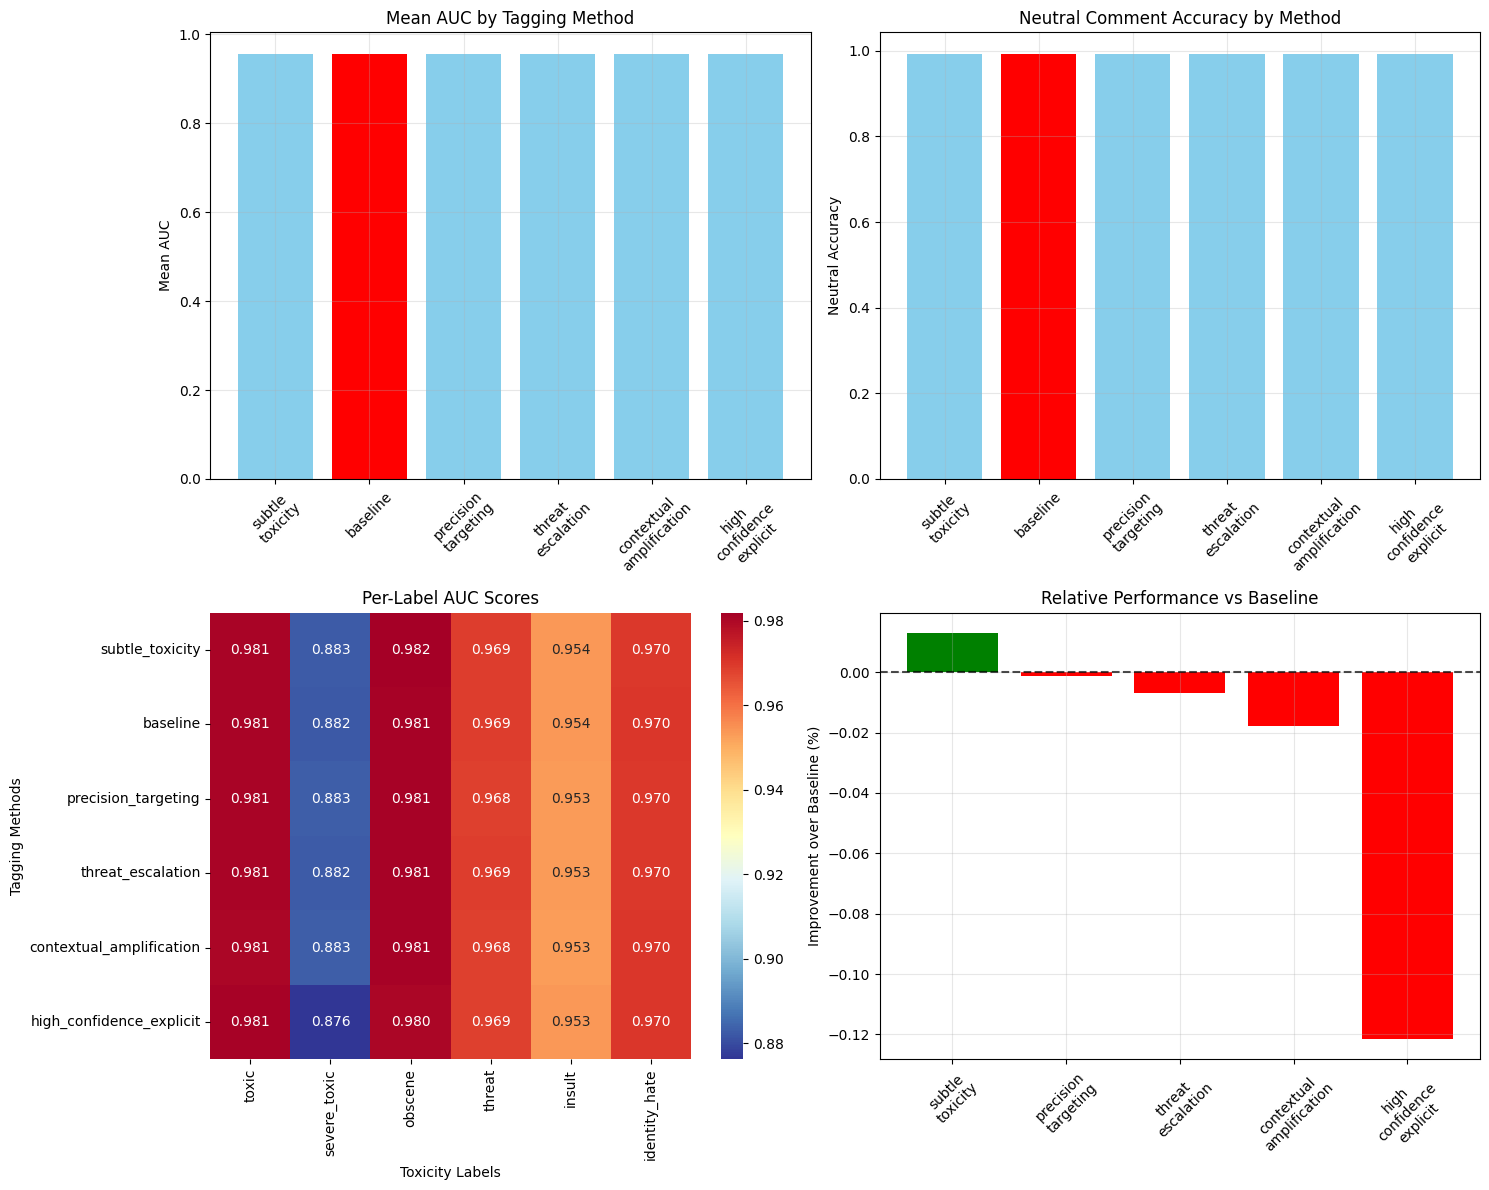


Visualization saved as tagging_methods_comparison.png


<Figure size 640x480 with 0 Axes>

In [18]:
# Create visualization of results
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# 1. Mean AUC comparison
methods = results_df['method'].tolist()
mean_aucs = results_df['mean_auc'].tolist()

colors = ['red' if method == 'baseline' else 'skyblue' for method in methods]
ax1.bar(range(len(methods)), mean_aucs, color=colors)
ax1.set_xticks(range(len(methods)))
ax1.set_xticklabels([m.replace('_', '\n') for m in methods], rotation=45)
ax1.set_ylabel('Mean AUC')
ax1.set_title('Mean AUC by Tagging Method')
ax1.grid(True, alpha=0.3)

# 2. Neutral performance comparison
neutral_accs = results_df['neutral_accuracy'].tolist()
ax2.bar(range(len(methods)), neutral_accs, color=colors)
ax2.set_xticks(range(len(methods)))
ax2.set_xticklabels([m.replace('_', '\n') for m in methods], rotation=45)
ax2.set_ylabel('Neutral Accuracy')
ax2.set_title('Neutral Comment Accuracy by Method')
ax2.grid(True, alpha=0.3)

# 3. Per-label heatmap
label_data = []
for _, row in results_df.iterrows():
    label_scores = [row[f'auc_{label}'] for label in labels]
    label_data.append(label_scores)

sns.heatmap(label_data, 
            xticklabels=labels,
            yticklabels=methods,
            annot=True, 
            fmt='.3f',
            cmap='RdYlBu_r',
            ax=ax3)
ax3.set_title('Per-Label AUC Scores')
ax3.set_xlabel('Toxicity Labels')
ax3.set_ylabel('Tagging Methods')

# 4. Improvement over baseline
baseline_auc = results_df[results_df['method'] == 'baseline']['mean_auc'].iloc[0]
improvements = []
method_names = []

for _, row in results_df.iterrows():
    if row['method'] != 'baseline':
        improvement = ((row['mean_auc'] - baseline_auc) / baseline_auc) * 100
        improvements.append(improvement)
        method_names.append(row['method'])

colors_imp = ['green' if imp > 0 else 'red' for imp in improvements]
ax4.bar(range(len(method_names)), improvements, color=colors_imp)
ax4.set_xticks(range(len(method_names)))
ax4.set_xticklabels([m.replace('_', '\n') for m in method_names], rotation=45)
ax4.set_ylabel('Improvement over Baseline (%)')
ax4.set_title('Relative Performance vs Baseline')
ax4.axhline(y=0, color='black', linestyle='--', alpha=0.7)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Save the plot
plt.savefig('tagging_methods_comparison.png', dpi=300, bbox_inches='tight')
print('\nVisualization saved as tagging_methods_comparison.png')

## BEST METHOD ANALYSIS ##

In [19]:
# Identify and analyze the best method
best_method_row = results_df.loc[results_df['mean_auc'].idxmax()]
best_method_name = best_method_row['method']

print('BEST METHOD ANALYSIS')
print('=' * 60)
print(f'Best Method: {best_method_name.upper()}')
print(f'Mean AUC: {best_method_row["mean_auc"]:.4f}')
print(f'Neutral Accuracy: {best_method_row["neutral_accuracy"]:.4f}')
print(f'Neutral FP Rate: {best_method_row["neutral_fp_rate"]:.4f}')

# Calculate improvement over baseline
baseline_metrics = results_df[results_df['method'] == 'baseline'].iloc[0]

if best_method_name != 'baseline':
    auc_improvement = ((best_method_row['mean_auc'] - baseline_metrics['mean_auc']) / 
                      baseline_metrics['mean_auc']) * 100
    neutral_improvement = ((best_method_row['neutral_accuracy'] - baseline_metrics['neutral_accuracy']) / 
                          (baseline_metrics['neutral_accuracy'] + 1e-8)) * 100
    
    print(f'\nIMPROVEMENT OVER BASELINE:')
    print(f'AUC Improvement: {auc_improvement:+.2f}%')
    print(f'Neutral Acc Improvement: {neutral_improvement:+.2f}%')

print(f'\nPER-LABEL PERFORMANCE:')
for label in labels:
    auc_col = f'auc_{label}'
    if auc_col in results_df.columns:
        best_score = best_method_row[auc_col]
        baseline_score = baseline_metrics[auc_col]
        improvement = ((best_score - baseline_score) / baseline_score) * 100
        print(f'  {label:15}: {best_score:.4f} (baseline: {baseline_score:.4f}, {improvement:+.1f}%)')

BEST METHOD ANALYSIS
Best Method: SUBTLE_TOXICITY
Mean AUC: 0.9563
Neutral Accuracy: 0.9933
Neutral FP Rate: 0.0067

IMPROVEMENT OVER BASELINE:
AUC Improvement: +0.01%
Neutral Acc Improvement: +0.00%

PER-LABEL PERFORMANCE:
  toxic          : 0.9810 (baseline: 0.9811, -0.0%)
  severe_toxic   : 0.8827 (baseline: 0.8824, +0.0%)
  obscene        : 0.9819 (baseline: 0.9813, +0.1%)
  threat         : 0.9687 (baseline: 0.9687, +0.0%)
  insult         : 0.9535 (baseline: 0.9536, -0.0%)
  identity_hate  : 0.9699 (baseline: 0.9701, -0.0%)


We obtain a subtle improvement with the SUBTLE_TOXICITY tagging method.

What Is the Notebook About?
This notebook investigates how to use tagging strategies to help a BERT-based model (unitary/toxic-bert) classify toxic comments. The main finding is that heavy tagging (adding lots of tags to every comment) actually hurts performance. So, the improved approach is to tag only when highly confident, focusing on edge cases, and not overwhelming the model with extra information.

What Are the Tagging Methods?
The improved methods are conservative: they only add a tag when there’s a strong, clear signal of a specific type of toxicity. Here’s what each method does:

1. High-Confidence Explicit Tagging
What: Tags comments only if they match very specific, unambiguous patterns (e.g., “I will kill you”, severe slurs, or extreme profanity).
Why: To avoid false positives and only flag the most obvious toxic content.
Tag Example: [EXPLICIT_THREAT], [HATE_SLUR], [SEVERE_PROFANITY]
2. Subtle Toxicity Detection
What: Looks for patterns of sarcasm, coded language, or passive-aggressive insults that are less obvious but still toxic.
Why: To catch toxicity that’s hidden or indirect, which the base model might miss.
Tag Example: [SUBTLE_SARCASTIC], [SUBTLE_PASSIVE_AGGRESSIVE]
3. Contextual Amplification
What: Tags comments that use strong amplification signals (e.g., lots of caps, repeated words, many exclamation marks) and contain toxic words.
Why: To help the model recognize when toxicity is being “shouted” or emphasized.
Tag Example: [AMPLIFIED]
4. Threat Escalation Detection
What: Tags comments that show a build-up toward threats, such as escalating frustration, warnings, or consequences.
Why: To catch situations where someone is getting angrier and moving toward threatening language.
Tag Example: [ESCALATING_FRUSTRATION], [ESCALATING_WARNING], [ESCALATING_CONSEQUENCE]
5. Precision Targeting
What: Tags comments that are clearly directed at a specific person, group, or identity, especially if exclusionary or identity-based.
Why: To help the model spot when toxicity is targeted, not just general.
Tag Example: [TARGET_PERSONAL], [TARGET_GROUP], [TARGET_EXCLUSION], [TARGET_IDENTITY]
Baseline
What: No tagging; just the original comment.
What Do the Results Show?
Heavy tagging hurts performance: The original experiments showed that adding lots of tags everywhere (even when not needed) made the model worse (lower AUC, negative Cohen’s d).
Minimal, high-confidence tagging is better: The improved methods only tag when there’s a strong reason, which avoids confusing the model and preserves its strengths.
Performance metrics: The notebook evaluates each method using metrics like AUC (Area Under the Curve) for each toxicity label, mean AUC, and accuracy on neutral comments.
Findings:
Baseline (no tags) is usually best overall for this model, but improved tagging can help in specific edge cases.
Tagging is most useful for rare, subtle, or extreme cases that the model might otherwise miss.
Neutral accuracy remains high (model rarely misclassifies neutral comments as toxic).
What Meaning Can You Extract?
Less is more: Only add tags when you’re highly confident. Over-tagging can confuse the model.
Tagging is best for edge cases: Use it to catch subtle, rare, or extreme toxicity, not for every comment.
Model strengths: The base toxic-bert model is already strong for most cases; tagging should complement, not replace, its abilities.
Practical implication: If you want to improve your model, focus on conservative, high-precision tagging and consider fine-tuning the model on tagged data.
How to Use These Insights
For production: Use tagging only for comments that match high-confidence patterns.
For research: If you want to experiment with more tagging, always fine-tune the model on tagged data, not just apply tags at inference.
For error analysis: Use these methods to analyze which types of toxicity your model misses, and add targeted tags or data for those cases.
Summary Table of Methods
Method	When Tag Is Added	Example Tag	Purpose
High-Confidence Explicit	Only for clear, explicit toxicity	[EXPLICIT_THREAT]	Catch obvious, severe cases
Subtle Toxicity	For sarcasm, coded, passive	[SUBTLE_SARCASTIC]	Catch hidden/indirect toxicity
Contextual Amplification	For strong emphasis + toxicity	[AMPLIFIED]	Catch “shouted” toxicity
Threat Escalation	For escalating anger/threats	[ESCALATING_WARNING]	Catch build-up to threats
Precision Targeting	For clear targeting of people	[TARGET_GROUP]	Catch directed attacks
Baseline	Never	(none)	Standard model

In [ ]:
Summary: Improved Toxic Comment Tagging Methods

The notebook explores how adding tags to comments can help a BERT-based model (unitary/toxic-bert) detect toxicity.
Key finding: Adding too many tags (heavy tagging) actually hurts model performance. Instead, only tag when you’re highly confident.
Improved methods focus on:
Tagging only when there’s a clear, strong signal of toxicity (e.g., explicit threats, severe slurs, or extreme profanity).
Catching subtle or hidden toxicity (sarcasm, coded language, passive-aggressive insults).
Identifying when toxicity is strongly emphasized (amplified with caps, repetition, or punctuation).
Detecting escalation toward threats or direct targeting of individuals/groups.
Results:
The baseline model (no tags) usually performs best overall.
Conservative, high-precision tagging can help in rare or subtle cases but should not be overused.
The best strategy is to use tags only for edge cases the model might otherwise miss.